> # CSE676 - Deep Learning
>> ## Final Project - Deep Q-Learning To Solve Complex Environments
>>> ### Submitted by: Ratik Dubey, Denver Dsouza and Tyler Banks

In [ ]:
# Importing the necessary modules
!pip3 install Cython
!pip3 install Box2D
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
from gym import spaces
from google.colab import widgets
import time
import random as random
from torch.autograd import Variable
from copy import deepcopy


## Environments 

In [ ]:
# Exploring CartPole-v1
envCart = gym.make('CartPole-v1')             
state_size = envCart.observation_space.shape[0]
print('Number of states:', state_size)
action_size = envCart.action_space.n
print('Number of actions:', action_size)

episode_reward = []
for i_episode in range(200):
    prevState = envCart.reset()
    total_reward = 0
    for t in range(100):
        # envCart.render()
        action = envCart.action_space.sample()
        prevState, reward, done, info = envCart.step(action)
        total_reward+=reward
        if done:
            break
    episode_reward.append(total_reward)
print("Average Score: "+str(sum(episode_reward) / len(episode_reward)))
envCart.close()


Number of states: 4
Number of actions: 2
Average Score: 22.235


In [ ]:
# Exploring LunarLander-v2
envLunar = gym.make('LunarLander-v2')             
state_size = envLunar.observation_space.shape[0]
print('Number of states:', state_size)
action_size = envLunar.action_space.n
print('Number of actions:', action_size)

episode_reward = []
for i_episode in range(200):
    prevState = envLunar.reset()
    total_reward = 0
    for t in range(100):
        # envLunar.render()
        action = envLunar.action_space.sample()
        prevState, reward, done, info = envLunar.step(action)
        total_reward+=reward
        if done:
            break
    episode_reward.append(total_reward)
print("Average Score: "+str(sum(episode_reward) / len(episode_reward)))
envLunar.close()


Number of states: 8
Number of actions: 4
Average Score: -153.43548886171277


In [ ]:
# Grid Environment 

class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def generate_one_hot(self, state):
      temp = []
      for i in range(16):
        temp.append(0)
      temp[state] = 1
      return temp
    
    def __init__(self, is_deterministic = True, reward_positions = {
            (3,3): 10,
            (1,3):2,
            (2,1):5,
            (2,2):-4
        }, max_timesteps = 7):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
        self.is_deterministic = is_deterministic
        self.reward_positions = reward_positions
        self.goal_pos = [3,3]
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 22
        self.rewards_consumed = {}
        for position in self.reward_positions:
          self.state[position[0]][position[1]] = self.reward_positions[position]
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        reward = 0

        if (not self.is_deterministic):
          prob = np.random.uniform()
          if (prob>0.9):
            options = [x  for x in range(4) if x!=action]
            action = options[np.random.randint(0,len(options)-1)]
         
        if action == 0: # down
          self.agent_pos[0] += 1 
        if action == 1: # up
          self.agent_pos[0] -= 1
        if action == 2: # right
          self.agent_pos[1] += 1
        if action == 3: # left
          self.agent_pos[1] -= 1

        old = self.agent_pos 
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))

        for position in self.reward_positions:
          if(self.agent_pos == position).all() and position not in self.rewards_consumed:
            reward += self.reward_positions[position]
            self.rewards_consumed[position] = True
          
          self.state[position[0]][position[1]] = self.reward_positions[position]
        
        self.state[tuple(self.agent_pos)] = 22
        observation = self.state.flatten()
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps or (self.agent_pos == self.goal_pos).all() else False
        new_state = (self.agent_pos[0]*4) + self.agent_pos[1]
        return self.generate_one_hot(new_state), reward, done, info # observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)
        

## DQN and Double-DQN Algorithms

In [ ]:
# Implementing DQN

class DQN():

  def __init__(self, inputDim, outputDim, hiddenDim=16, alpha=0.01, double=False):
    self.double = double
    self.loss_function = torch.nn.MSELoss()
    self.model = torch.nn.Sequential(
                              torch.nn.Linear(inputDim, hiddenDim),
                              torch.nn.LeakyReLU(),
                              torch.nn.Linear(hiddenDim, hiddenDim*2),
                              torch.nn.LeakyReLU(),
                              torch.nn.Linear(hiddenDim*2, outputDim)
                              )
    self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
    if self.double: 
      # The second model below is used for double DQN.
      self.target = deepcopy(self.model)

  def update(self, state, target):
      output = self.model(torch.Tensor(np.array(state)))
      loss = self.loss_function(output, torch.Tensor(np.array(target)))
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

  def predict(self, state):
      return self.model(torch.Tensor(np.array(state)))
  
  def target_update(self):
      self.target.load_state_dict(self.model.state_dict())
  
  def target_predict(self, state):
      return self.model(torch.Tensor(np.array(state)))

  def replay(self, memory, size, gamma=0.9):
      batch = random.sample(memory, size)
      states, targets = [], []
      for reward, done, action, prevState, newState in batch:
        Q_prev_state = self.predict(prevState).tolist()
        if done:
            Q_prev_state[action] = reward
        else:
            if (self.double):
              Q_next_state = self.target_predict(newState)
            else:
              Q_next_state = self.predict(newState)
            Q_prev_state[action] = reward + gamma * torch.max(Q_next_state).item()
        states.append(prevState)
        targets.append(Q_prev_state)
      self.update(states, targets)
      

## Agent

In [ ]:
# Agent Definition

class RandomAgent:
  
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

  def train_DQN(self, model, episodes=100, gamma=0.9):
    epsilon = 1
    decay_factor = (0.01/1.0)**(1/episodes)
    plot_data = []
    replay_memory = []
    replay_size = 20
    for episode in range(episodes):
      done = False
      obs = self.env.reset()
      prevState, reward, done, _  = self.env.step(0)
      step = 1
      epsilon*=decay_factor
      total_reward = 0
      while not done:
        action = self.step(obs)
        prob = np.random.uniform()
        if (prob>epsilon):
          Q_prev_state = model.predict(prevState).tolist()
          action = np.argmax(Q_prev_state)
        newState, reward, done, _ = self.env.step(action)
        step+=1
        total_reward+=reward
        replay_memory.append([reward, done, action, prevState, newState])            
        if not done and len(replay_memory)>replay_size:
          model.replay(replay_memory, replay_size, gamma)
        prevState=newState
      plot_data.append([episode+1, epsilon, total_reward])
    return model, plot_data

  def train_double_DQN(self, model, episodes=100, gamma=0.8, update_steps=10):
    epsilon = 1
    decay_factor = (0.01/1.0)**(1/episodes)
    plot_data = []
    replay_memory = []
    replay_size = 128
    for episode in range(episodes):
      if episode%update_steps == 0:
        model.target_update()
      done = False
      obs = self.env.reset()
      prevState, reward, done, _  = self.env.step(0)
      step = 1
      epsilon*=decay_factor
      total_reward = 0
      while not done:
        action = self.step(obs)
        prob = np.random.uniform()
        if (prob>epsilon):
          Q_prev_state = model.predict(prevState).tolist()
          action = np.argmax(Q_prev_state)
        newState, reward, done, _ = self.env.step(action)
        step+=1
        total_reward+=reward
        replay_memory.append([reward, done, action, prevState, newState])            
        if not done and len(replay_memory)>replay_size:
          model.replay(replay_memory, replay_size, gamma)
        prevState=newState
      plot_data.append([episode+1, epsilon, total_reward])
    return model, plot_data
    

## DQN Training and Results

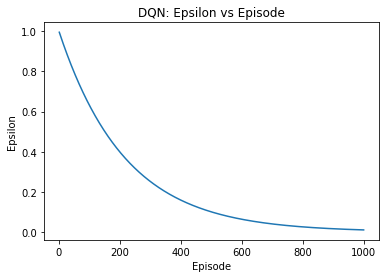

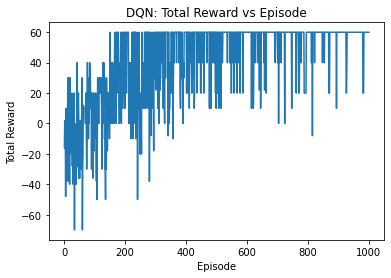

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

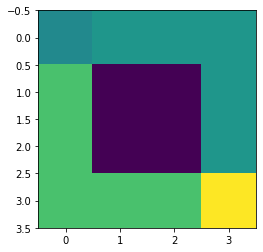

<IPython.core.display.Javascript object>

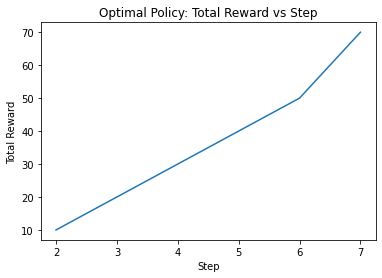

In [ ]:
# DQN - GRID WORLD

# Initialising environment object
is_deterministic=True
episodes=1000
max_timesteps=7
model = DQN(16,4)

env = GridEnvironment(is_deterministic=is_deterministic, reward_positions={
              (3,3): 20,
              (1,3):2,
              (2,3):2,
              (0,1):2,
              (0,2):2,
              (0,3):2,
              (3,1):10,
              (3,2):10,
              (1,0):10,
              (2,0):10,
              (3,0):10,
              (1,1):-20,
              (2,1):-20,
              (1,2):-20,
              (2,2):-20
          }, max_timesteps = max_timesteps)

env.reset()
agent = RandomAgent(env)
DQN_model, plot_data = agent.train_DQN(model=model, episodes=episodes)


# Plots - Epsilon Decay and Total Reward per Episode
plot_data = np.array(plot_data)
figure_count=0
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,1])
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title("DQN: Epsilon vs Episode")
plt.show()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,2])
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title("DQN: Total Reward vs Episode")
plt.show()


# Visualising Agent Movement
obs = env.reset()
done = False
output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()
prevState = env.generate_one_hot(0)
total_reward = 0
step = 1
plot_data_opt = []
while not done:
  opt_action = torch.argmax(DQN_model.predict(prevState))
  prevState, reward, done, _ = env.step(opt_action)
  total_reward+=reward
  step+=1
  plot_data_opt.append([step, total_reward])
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    env.render()
  time.sleep(1)

print('\n')
plot_data_opt = np.array(plot_data_opt)
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data_opt[:,0],plot_data_opt[:,1])
plt.ylabel('Total Reward')
plt.xlabel('Step')
plt.title("Optimal Policy: Total Reward vs Step")
plt.show()


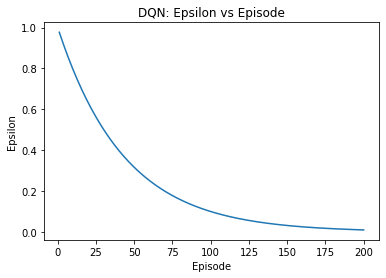

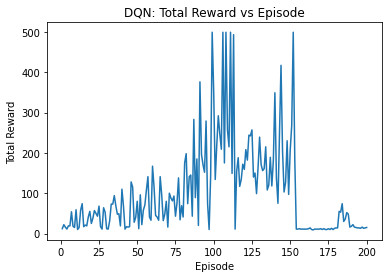

Average Score: 14.89




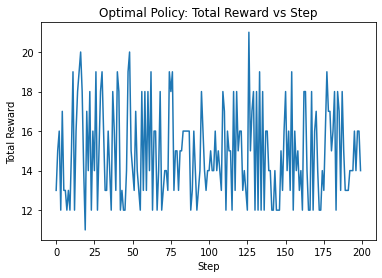

In [ ]:
# DQN - CartPole

# Train CartPole
envCart = gym.make('CartPole-v1')             
envCart.reset()
state_size = envCart.observation_space.shape[0]
action_size = envCart.action_space.n
agent = RandomAgent(envCart)
model1 = DQN(state_size,action_size,hiddenDim=24)
DQN_model, plot_data = agent.train_DQN(model=model1, episodes=200)


# Plots - Epsilon Decay and Total Reward per Episode
plot_data = np.array(plot_data)
figure_count=0
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,1])
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title("DQN: Epsilon vs Episode")
plt.show()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,2])
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title("DQN: Total Reward vs Episode")
plt.show()


# Visualising Agent Movement
episode_reward = []
for i_episode in range(200):
    prevState = envCart.reset()
    total_reward = 0
    for t in range(1000):
        # envCart.render()
        opt_action = torch.argmax(DQN_model.predict(prevState)).numpy()
        prevState, reward, done, info = envCart.step(opt_action)
        total_reward+=reward
        if done:
            break
    episode_reward.append([i_episode, total_reward])
episode_reward = np.array(episode_reward)
print("Average Score: "+str(sum(episode_reward[:,1]) / len(episode_reward)))
envCart.close()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(episode_reward[:,0],episode_reward[:,1])
plt.ylabel('Total Reward')
plt.xlabel('Step')
plt.title("Optimal Policy: Total Reward vs Step")
plt.show()


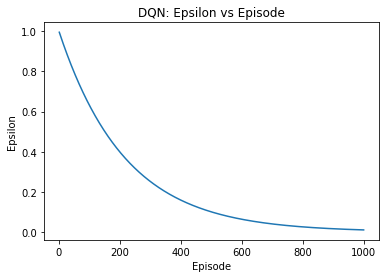

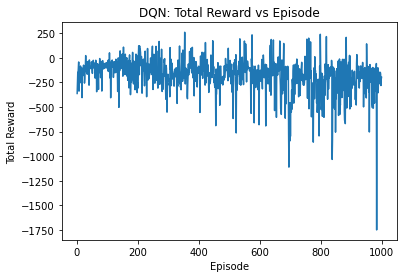

Average Score: -132.97520739292412




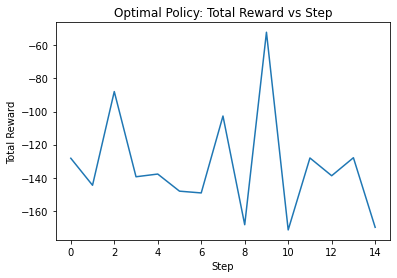

In [ ]:
# DQN - LunarLander

# Train Lunar Lander
envLunar = gym.make('LunarLander-v2')              
envLunar.reset()
state_size = envLunar.observation_space.shape[0]
action_size = envLunar.action_space.n
agent = RandomAgent(envLunar)
model1 = DQN(state_size,action_size,hiddenDim=32)
DQN_model, plot_data = agent.train_DQN(model=model1, episodes=1000)


# Plots - Epsilon Decay and Total Reward per Episode
plot_data = np.array(plot_data)
figure_count=0
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,1])
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title("DQN: Epsilon vs Episode")
plt.show()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,2])
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title("DQN: Total Reward vs Episode")
plt.show()


# Visualising Agent Movement
episode_reward = []
for i_episode in range(15):
    prevState = envLunar.reset()
    total_reward = 0
    for t in range(1000):
        # envLunar.render()
        opt_action = torch.argmax(DQN_model.predict(prevState)).numpy()
        prevState, reward, done, info = envLunar.step(opt_action)
        total_reward+=reward
        if done:
            break
    episode_reward.append([i_episode, total_reward])
    
episode_reward = np.array(episode_reward)
print("Average Score: "+str(sum(episode_reward[:,1]) / len(episode_reward)))
envLunar.close()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(episode_reward[:,0],episode_reward[:,1])
plt.ylabel('Total Reward')
plt.xlabel('Step')
plt.title("Optimal Policy: Total Reward vs Step")
plt.show()


## Double-DQN Training and Results

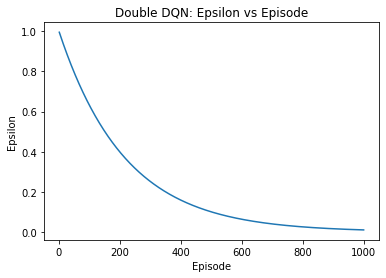

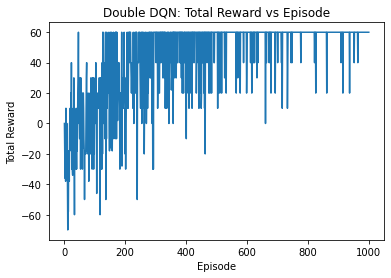

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

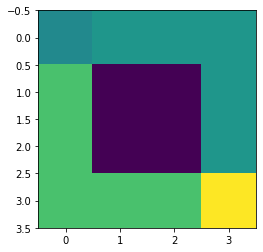

<IPython.core.display.Javascript object>

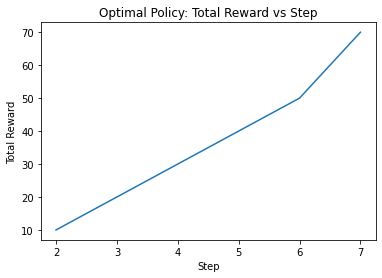

In [ ]:
# Double-DQN - GRID WORLD

# Initialising environment object
is_deterministic=True
episodes=1000
max_timesteps=7
gamma=0.9
update_steps=10
model = DQN(16,4,double=True)

env = GridEnvironment(is_deterministic=is_deterministic, reward_positions={
              (3,3): 20,
              (1,3):2,
              (2,3):2,
              (0,1):2,
              (0,2):2,
              (0,3):2,
              (3,1):10,
              (3,2):10,
              (1,0):10,
              (2,0):10,
              (3,0):10,
              (1,1):-20,
              (2,1):-20,
              (1,2):-20,
              (2,2):-20
          }, max_timesteps = max_timesteps)

env.reset()
agent = RandomAgent(env)
double_DQN_model, plot_data = agent.train_double_DQN(model=model, episodes=episodes)


# Plots - Epsilon Decay and Total Reward per Episode
plot_data = np.array(plot_data)
figure_count=0
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,1])
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title("Double DQN: Epsilon vs Episode")
plt.show()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,2])
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title("Double DQN: Total Reward vs Episode")
plt.show()


# Visualising Agent Movement
obs = env.reset()
done = False
output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()
prevState = env.generate_one_hot(0)
total_reward = 0
step = 1
plot_data_opt = []
while not done:
  opt_action = torch.argmax(double_DQN_model.predict(prevState))
  prevState, reward, done, _ = env.step(opt_action)
  total_reward+=reward
  step+=1
  plot_data_opt.append([step, total_reward])
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    env.render()
  time.sleep(1)

print('\n')
plot_data_opt = np.array(plot_data_opt)
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data_opt[:,0],plot_data_opt[:,1])
plt.ylabel('Total Reward')
plt.xlabel('Step')
plt.title("Optimal Policy: Total Reward vs Step")
plt.show()


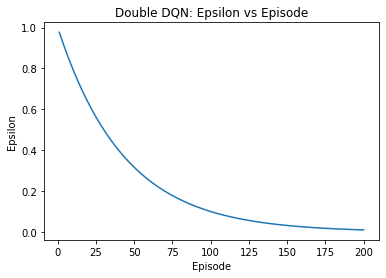

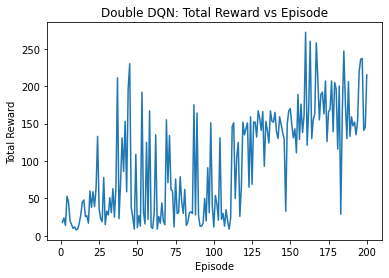

Average Score: 138.46666666666667




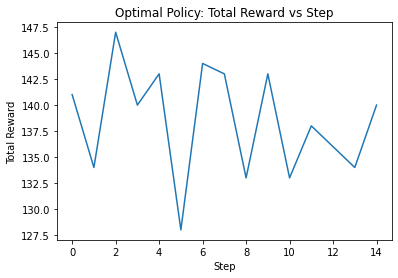

In [ ]:
# Double-DQN - CartPole

# Train CartPole
envCart = gym.make('CartPole-v1')             
envCart.reset()
state_size = envCart.observation_space.shape[0]
action_size = envCart.action_space.n
agent = RandomAgent(envCart)
model1 = DQN(state_size,action_size,hiddenDim=state_size*2, double=True)
double_DQN_model, plot_data = agent.train_double_DQN(model=model1, episodes=200)


# Plots - Epsilon Decay and Total Reward per Episode
plot_data = np.array(plot_data)
figure_count=0
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,1])
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title("Double DQN: Epsilon vs Episode")
plt.show()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,2])
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title("Double DQN: Total Reward vs Episode")
plt.show()


# Visualising Agent Movement
episode_reward = []
for i_episode in range(15):
    prevState = envCart.reset()
    total_reward = 0
    for t in range(1000):
        # envCart.render()
        opt_action = torch.argmax(double_DQN_model.predict(prevState)).numpy()
        prevState, reward, done, info = envCart.step(opt_action)
        total_reward+=reward
        if done:
            break
    episode_reward.append([i_episode, total_reward])

episode_reward = np.array(episode_reward)
print("Average Score: "+str(sum(episode_reward[:,1]) / len(episode_reward)))
envCart.close()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(episode_reward[:,0],episode_reward[:,1])
plt.ylabel('Total Reward')
plt.xlabel('Step')
plt.title("Optimal Policy: Total Reward vs Step")
plt.show()


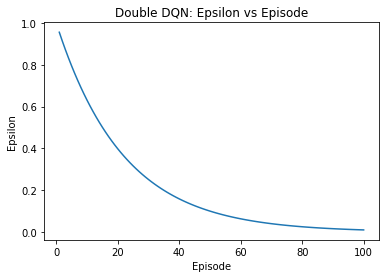

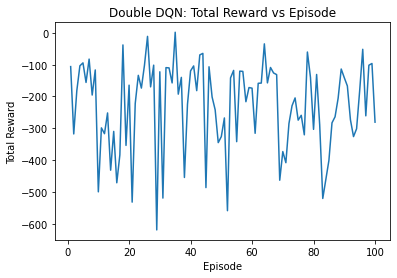

Average Score: -464.4701063836545




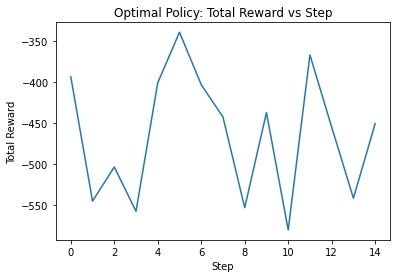

In [ ]:
# Double-DQN - LunarLander

# Train Lunar Lander
envLunar = gym.make('LunarLander-v2')              
envLunar.reset()
state_size = envLunar.observation_space.shape[0]
action_size = envLunar.action_space.n
agent = RandomAgent(envLunar)
model1 = DQN(state_size,action_size,hiddenDim=8, double=True)
double_DQN_model, plot_data = agent.train_double_DQN(model=model1, episodes=100)


# Plots - Epsilon Decay and Total Reward per Episode
plot_data = np.array(plot_data)
figure_count=0
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,1])
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title("Double DQN: Epsilon vs Episode")
plt.show()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(plot_data[:,0],plot_data[:,2])
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title("Double DQN: Total Reward vs Episode")
plt.show()


# Visualising Agent Movement
episode_reward = []
for i_episode in range(15):
    prevState = envLunar.reset()
    total_reward = 0
    for t in range(1000):
        # envLunar.render()
        opt_action = torch.argmax(double_DQN_model.predict(prevState)).numpy()
        prevState, reward, done, info = envLunar.step(opt_action)
        total_reward+=reward
        if done:
            break
    episode_reward.append([i_episode, total_reward])
    
episode_reward = np.array(episode_reward)
print("Average Score: "+str(sum(episode_reward[:,1]) / len(episode_reward)))
envLunar.close()

print('\n')
plt.figure(figure_count)
figure_count+=1
plt.plot(episode_reward[:,0],episode_reward[:,1])
plt.ylabel('Total Reward')
plt.xlabel('Step')
plt.title("Optimal Policy: Total Reward vs Step")
plt.show()
